# 0. Imports

In [1]:
import scipy
import numpy as np
import pandas as pd
#import boruta as bt
import xgboost as xgb
import seaborn as sns
import lightgbm as lgb
import matplotlib.pyplot as plt

from sklearn import svm
from sklearn import tree

from sklearn import metrics as mt
from sklearn import ensemble as en
from sklearn import linear_model as lm
from sklearn import kernel_ridge as kr
from sklearn import preprocessing as pp
from sklearn import neural_network as nn
from sklearn import model_selection as ms
from sklearn import gaussian_process as gp
from sklearn import cross_decomposition as cd

from statsmodels import api

In [2]:
def settings():
    %matplotlib inline
    plt.style.use('bmh')
    plt.rcParams['figure.figsize'] = [20, 10]
    plt.rcParams['font.size'] = 24
    #display( HTML( '') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option('display.float_format', lambda x: '%.4f' % x)
    pd.set_option( 'display.expand_frame_repr', False )
    sns.set()

settings()

def cramer_v(x, y):

    cm = pd.crosstab(x, y).to_numpy()
    n = cm.sum()
    r, k = cm.shape
    chi2 = scipy.stats.chi2_contingency(cm)[0]
    chi2corr = max(0, chi2 - (k - 1) * (r - 1) / (n - 1))
    kcorr = k - (k - 1) ** 2 / (n - 1)
    rcorr = r - (r - 1) ** 2 / (n - 1)

    return np.sqrt((chi2corr / n) / (min( kcorr-1, rcorr-1)))

def mean_percentage_error(y, yhat):
    return np.mean((y - yhat) / y)

def mean_absolute_percentage_error(y, yhat):
    return np.mean(np.abs((y - yhat) / y))

def ml_error(model_name, y, yhat):
    mae = mt.mean_absolute_error(y, yhat)
    mape = mean_absolute_percentage_error(y, yhat)
    rmse = np.sqrt(mt.mean_squared_error(y, yhat))

    return pd.DataFrame({'Model Name': model_name,
                         'MAE': mae,
                         'MAPE': mape,
                         'RMSE': rmse}, index=[0])

def ml_metrics(y, yhat):
    mae = mt.mean_absolute_error(y, yhat)
    mape = mean_absolute_percentage_error(y, yhat)
    rmse = np.sqrt(mt.mean_squared_error(y, yhat))

    return mae, mape, rmse

def cross_validation(models_performance_cv, num_folds, model_name, model, mm_production, x_train, y_train):

    kfold = ms.KFold(n_splits=num_folds, shuffle=True, random_state=42)
    
    mae_list = []
    mape_list = []
    rmse_list = []
    
    i=1

    for train_cv, val_cv in kfold.split(x_train, y_train):

        # separate train folds and val fold
        x_train_fold = x_train.iloc[train_cv].copy()
        y_train_fold = y_train.iloc[train_cv].copy()

        x_val_fold = x_train.iloc[val_cv].copy()
        y_val_fold = y_train.iloc[val_cv].copy()

        # train model
        model_fit = model.fit(x_train_fold, y_train_fold)

        # predict values with trained model
        yhat_model = model_fit.predict(x_val_fold)
    
        #performance
        m_result = ml_error(model_name, mm_production.inverse_transform([y_val_fold]), mm_production.inverse_transform([yhat_model]))

        # store performance of each kfold iteration
        mae_list.append(m_result['MAE'])
        mape_list.append(m_result['MAPE'])
        rmse_list.append(m_result['RMSE'])

        print(f"{model_name} Fold {i} Finished")

        i+=1

    model_performance = pd.DataFrame({'Model Name': model_name,
                                       'MAE CV': np.round(np.mean(mae_list), 2).astype(str) + ' +/- ' + np.round(np.std(mae_list), 2).astype(str),
                                       'MAPE CV': np.round(np.mean(mape_list), 2).astype(str) + ' +/- ' + np.round(np.std(mape_list), 2).astype(str),
                                       'RMSE CV': np.round(np.mean(rmse_list), 2).astype(str) + ' +/- ' + np.round(np.std(rmse_list), 2).astype(str),}, index=[0])

    models_performance_cv = pd.concat([models_performance_cv, model_performance])
        
    return models_performance_cv

# 1. Data Exploration

In [8]:
x1 = pd.read_csv('x.csv')
y1 = pd.read_csv('y.csv')

In [9]:
df1 = pd.concat([x1, y1], axis=1)

In [10]:
df1.head()

,ID,FC,age,weight,height,gender,VO2
0,1,54,42.1000,76.0000,167.0000,0,386
1,2,91,42.1000,76.0000,167.0000,0,506
2,3,93,42.1000,76.0000,167.0000,0,500
3,4,94,42.1000,76.0000,167.0000,0,462
4,5,95,42.1000,76.0000,167.0000,0,548


In [11]:
df1.columns

Index(['ID', 'FC', 'age', 'weight', 'height', 'gender', 'VO2'], dtype='object')

In [12]:
print('Number of Rows: {}'.format(df1.shape[0]))
print('Number of Cols: {}'.format(df1.shape[1]))

Number of Rows: 478424
Number of Cols: 7


In [13]:
df1.dtypes

ID          int64
FC          int64
age       float64
weight    float64
height    float64
gender      int64
VO2         int64
dtype: object

In [14]:
df1.isna().sum()

ID        0
FC        0
age       0
weight    0
height    0
gender    0
VO2       0
dtype: int64

In [15]:
numerical_attributes = df1.select_dtypes(include=['int64', 'float64'])

In [16]:
# Central Tendency: mean, median
ct1 = pd.DataFrame(numerical_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(numerical_attributes.apply(np.median)).T

# Dispersion: std, min, max, range, skew, kurtosis
d1 = pd.DataFrame(numerical_attributes.apply(np.std)).T
d2 = pd.DataFrame(numerical_attributes.apply(min)).T
d3 = pd.DataFrame(numerical_attributes.apply(max)).T
d4 = pd.DataFrame(numerical_attributes.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(numerical_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(numerical_attributes.apply(lambda x: x.kurtosis())).T

# concatenate
m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,ID,1.0000,1008.0000,1007.0000,301.5043,286.0000,189.7132,0.3891,-0.6110
1,FC,0.0000,226.0000,226.0000,145.3322,151.0000,32.2676,-0.4622,-0.7114
2,age,18.0000,63.0000,45.0000,31.0368,29.3000,9.0980,0.6937,-0.1250
3,weight,41.9000,135.0000,93.1000,74.4184,74.0000,11.1386,0.5723,1.9057
4,height,151.0000,201.0000,50.0000,175.4782,176.0000,7.6976,-0.0922,0.2745
5,gender,0.0000,1.0000,1.0000,0.1213,0.0000,0.3265,2.3198,3.3815
6,VO2,-5.0000,6217.0000,6222.0000,2337.9940,2342.0000,986.7097,0.1791,-0.7995


In [17]:
df1[['gender']].value_counts()

gender
0         420387
1          58037
Name: count, dtype: int64

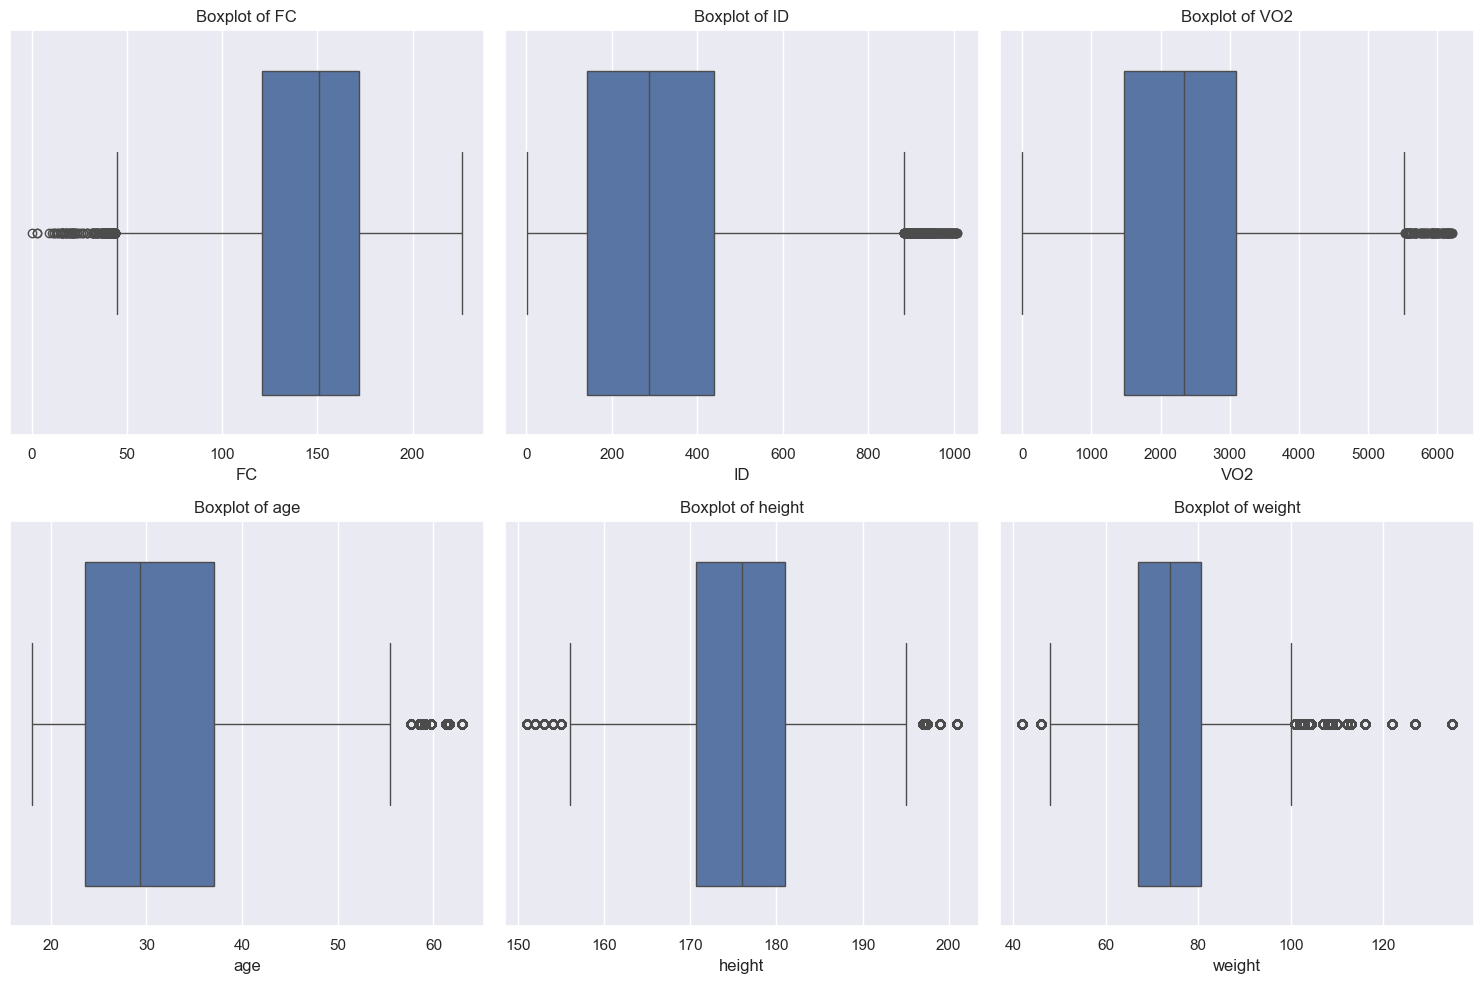

In [73]:
columns_to_plot = df1.columns.difference(['gender'])
num_plots = len(columns_to_plot)
num_rows = (num_plots // 3) + (num_plots % 3 > 0)

fig, axes = plt.subplots(nrows=num_rows, ncols=3, figsize=(15, 5*num_rows))

for i, column in enumerate(columns_to_plot):
    row = i // 3
    col = i % 3
    sns.boxplot(data=df1, x=column, ax=axes[row, col])
    axes[row, col].set_title(f"Boxplot of {column}")

plt.tight_layout()
plt.show()

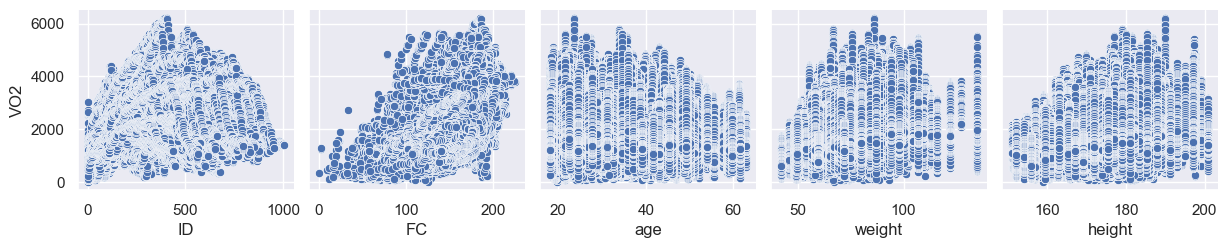

In [74]:
sns.pairplot(df1, y_vars='VO2', x_vars=['ID', 'FC', 'age', 'weight', 'height']);

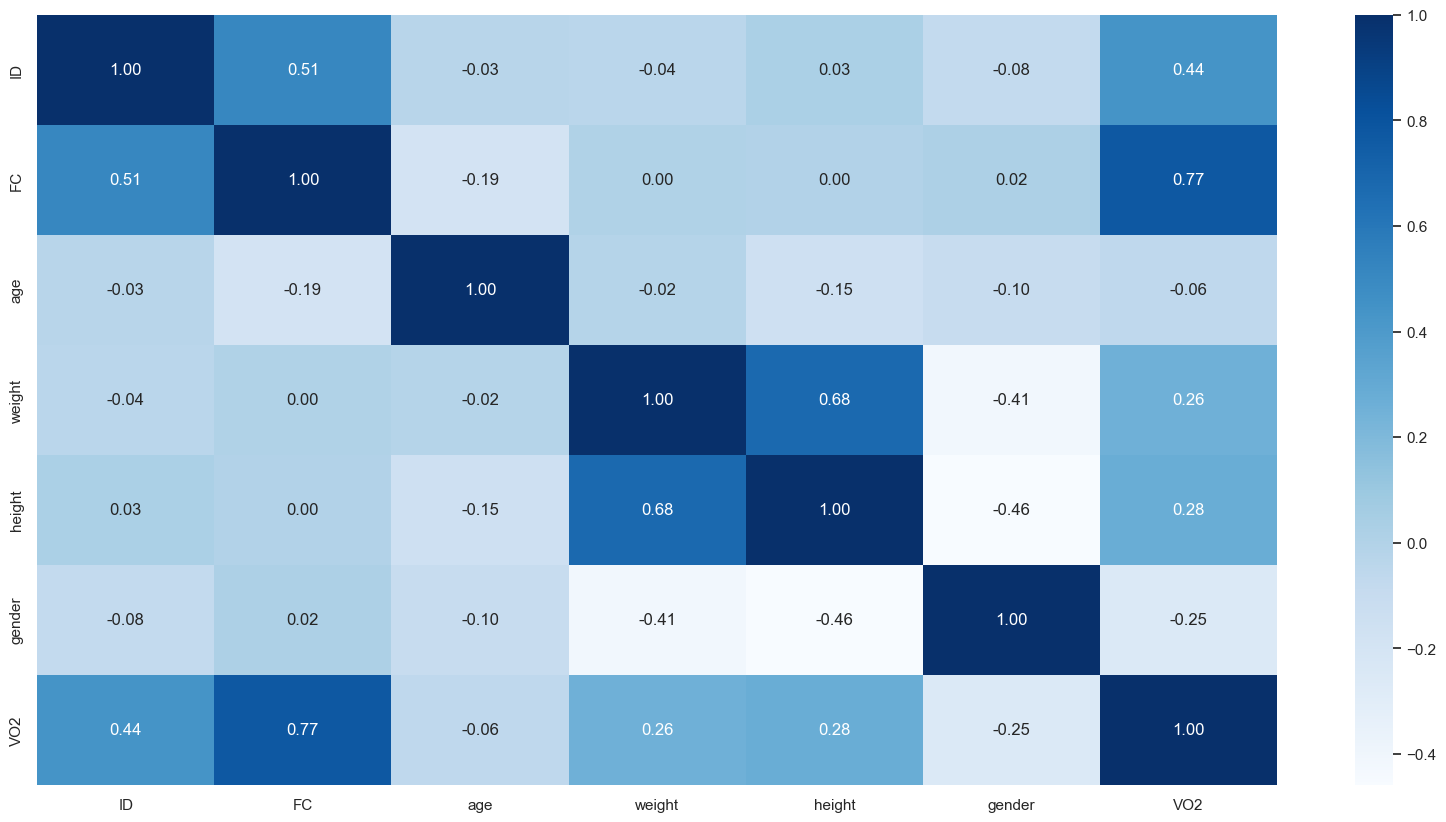

In [75]:

correlation = df1.corr(method='pearson');
sns.heatmap(correlation, cmap="Blues", annot=True, fmt='.2f');

# 2. Split and Variables Exploration

In [18]:
df2 = df1.copy()

In [19]:
x = df2.drop(['VO2'], axis=1)
y = df2['VO2'].copy()

In [20]:
x_train, x_test, y_train, y_test = ms.train_test_split(x, y, test_size=0.20)

df2_train = pd.concat([x_train, y_train], axis=1)
df2_test = pd.concat([x_test, y_test], axis=1)

In [21]:
target_encoder_gender = df2_train.groupby('gender')['VO2'].mean()
df2_train['gender'] = df2_train['gender'].map(target_encoder_gender)

mms_ID = pp.MinMaxScaler()
mms_FC = pp.MinMaxScaler()
mms_age = pp.MinMaxScaler()
mms_weight = pp.MinMaxScaler()
mms_height = pp.MinMaxScaler()

df2_train['ID'] = mms_ID.fit_transform(df2_train[['ID']].values)
df2_train['FC'] = mms_FC.fit_transform(df2_train[['FC']].values)
df2_train['age'] = mms_age.fit_transform(df2_train[['age']].values)
df2_train['weight'] = mms_weight.fit_transform(df2_train[['weight']].values)
df2_train['height'] = mms_height.fit_transform(df2_train[['height']].values)

mms_VO2 = pp.MinMaxScaler()
df2_train['VO2'] = mms_VO2.fit_transform(df2_train[['VO2']].values)

In [22]:
df2_test['gender'] = df2_test['gender'].map(target_encoder_gender)

df2_test['ID'] = mms_ID.transform(df2_test[['ID']].values)
df2_test['FC'] = mms_FC.transform(df2_test[['FC']].values)
df2_test['age'] = mms_age.transform(df2_test[['age']].values)
df2_test['weight'] = mms_weight.transform(df2_test[['weight']].values)
df2_test['height'] = mms_height.transform(df2_test[['height']].values)

df2_test['VO2'] = mms_VO2.transform(df2_test[['VO2']].values)

In [23]:
df3_train = df2_train.copy()
df3_test = df2_test.copy()

In [24]:
x_train = df3_train.drop(['VO2'], axis=1)
y_train = df3_train['VO2'].values.ravel()

x_test = df3_test.drop(['VO2'], axis=1)
y_test = df3_test['VO2'].values.ravel()

In [48]:
rf = en.RandomForestRegressor(n_jobs=-1, random_state=42)
rf.fit(x_train, y_train)

RandomForestRegressor(n_jobs=-1, random_state=42)

In [51]:
importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

print("Features Ranking:")
df = pd.DataFrame()
for i, j, k in zip(x_train, rf.feature_importances_, range(len(rf.feature_importances_))):
    aux = pd.DataFrame( {'feature': i, 'importance': j}, index=[k])
    df = pd.concat([df, aux], axis=0)
    
print(df.sort_values('importance', ascending=False))

columns_selected_tree_importance = ['FC',
                                    'ID',
                                    'weight',
                                    'height',
                                    'age',
                                    'gender_target_encode']

Features Ranking:
  feature  importance
1      FC      0.6028
0      ID      0.1089
3  weight      0.0768
5  gender      0.0733
4  height      0.0707
2     age      0.0675


# 3. Training

In [54]:
lr = lm.LinearRegression().fit(x_train, y_train)
yhat_lr = lr.predict(x_test)
lr_result = ml_error('LinearRegression', mms_VO2.inverse_transform([y_test]), mms_VO2.inverse_transform([yhat_lr]))
lr_result

,Model Name,MAE,MAPE,RMSE
0,LinearRegression,411.3438,0.2168,526.1135


In [56]:
rr = lm.Ridge().fit(x_train, y_train)
yhat_rr = rr.predict(x_test)
rr_result = ml_error('Ridge', mms_VO2.inverse_transform([y_test]), mms_VO2.inverse_transform([yhat_rr]))
rr_result

,Model Name,MAE,MAPE,RMSE
0,Ridge,411.3463,0.2168,526.1137


In [33]:
la = lm.Lasso().fit(x_train, y_train)
yhat_la = la.predict(x_test)
la_result = ml_error('Lasso', mms_VO2.inverse_transform([y_test]), mms_VO2.inverse_transform([yhat_la]))
la_result

,Model Name,MAE,MAPE,RMSE
0,Lasso,804.9342,0.4982,956.7090


In [34]:
enet = lm.ElasticNet().fit(x_train, y_train)
yhat_enet = enet.predict(x_test)
enet_result = ml_error('ElasticNet', mms_VO2.inverse_transform([y_test]), mms_VO2.inverse_transform([yhat_enet]))
enet_result

,Model Name,MAE,MAPE,RMSE
0,ElasticNet,804.5533,0.4976,956.4818


In [35]:
brr = lm.BayesianRidge().fit(x_train, y_train)
yhat_brr = brr.predict(x_test)
brr_result = ml_error('BayesianRidge', mms_VO2.inverse_transform([y_test]), mms_VO2.inverse_transform([yhat_brr]))
brr_result

,Model Name,MAE,MAPE,RMSE
0,BayesianRidge,411.3439,0.2168,526.1135


In [36]:
lla = lm.LassoLars().fit(x_train, y_train)
yhat_lla = lla.predict(x_test)
lla_result = ml_error('LassoLars', mms_VO2.inverse_transform([y_test]), mms_VO2.inverse_transform([yhat_lla]))
lla_result

,Model Name,MAE,MAPE,RMSE
0,LassoLars,804.9342,0.4982,956.7090


In [38]:
pr = api.GLM(y_train, x_train, family=api.families.Poisson()).fit()
yhat_pr = pr.predict(x_test)
pr_result = ml_error('Poisson', mms_VO2.inverse_transform([y_test]), mms_VO2.inverse_transform([yhat_pr]))
pr_result

,Model Name,MAE,MAPE,RMSE
0,Poisson,773.5265,0.4475,988.8175


In [39]:
gr = api.GLM(y_train, x_train, family=api.families.Gamma()).fit()
yhat_gr = gr.predict(x_test)
gr_result = ml_error('Gamma', mms_VO2.inverse_transform([y_test]), mms_VO2.inverse_transform([yhat_gr]))
gr_result

c:\Users\matheus.andrade.N305-3012153\anaconda3\envs\ecg\lib\site-packages\statsmodels\genmod\generalized_linear_model.py:308: DomainWarning: The InversePower link function does not respect the domain of the Gamma family.
  warnings.warn((f"The {type(family.link).__name__} link function "


,Model Name,MAE,MAPE,RMSE
0,Gamma,1309.6966,0.6710,22716.2873


In [96]:
#svmr = svm.SVR(verose=True).fit(x_train, y_train)
#yhat_svmr = svmr.predict(x_test)
#svmr_result = ml_error('SVM', mms_VO2.inverse_transform([y_test]), mms_VO2.inverse_transform([yhat_svmr]))
#svmr_result

,Model Name,MAE,MAPE,RMSE
0,SVM,792.9901,0.4817,941.6634


In [41]:
tr = tree.DecisionTreeRegressor(random_state=42).fit(x_train, y_train)
yhat_tr = tr.predict(x_test)
tr_result = ml_error('DecisionTreeRegressor', mms_VO2.inverse_transform([y_test]), mms_VO2.inverse_transform([yhat_tr]))
tr_result

,Model Name,MAE,MAPE,RMSE
0,DecisionTreeRegressor,52.7281,0.0297,103.5946


In [42]:
rf = en.RandomForestRegressor(random_state=42, verbose=0, n_jobs=-1).fit(x_train, y_train)
yhat_rf = rf.predict(x_test)
rf_result = ml_error('RandomForestRegressor', mms_VO2.inverse_transform([y_test]), mms_VO2.inverse_transform([yhat_rf]))
rf_result

,Model Name,MAE,MAPE,RMSE
0,RandomForestRegressor,44.1326,0.0249,74.8244


In [46]:
gb = en.GradientBoostingRegressor(random_state=42, verbose=0).fit(x_train, y_train)
yhat_gb = gb.predict(x_test)
gb_result = ml_error('GradientBoostingRegressor', mms_VO2.inverse_transform([y_test]), mms_VO2.inverse_transform([yhat_gb]))
gb_result

,Model Name,MAE,MAPE,RMSE
0,GradientBoostingRegressor,327.8483,0.1620,442.5697


In [48]:
ab = en.AdaBoostRegressor(random_state=42).fit(x_train, y_train)
yhat_ab = ab.predict(x_test)
ab_result = ml_error('AdaBoostRegressor', mms_VO2.inverse_transform([y_test]), mms_VO2.inverse_transform([yhat_ab]))
ab_result

,Model Name,MAE,MAPE,RMSE
0,AdaBoostRegressor,457.8929,0.2738,575.9442


In [49]:
bag = en.BaggingRegressor(random_state=42, verbose=0, n_jobs=-1).fit(x_train, y_train)
yhat_bag = bag.predict(x_test)
bag_result = ml_error('BaggingRegressor', mms_VO2.inverse_transform([y_test]), mms_VO2.inverse_transform([yhat_bag]))
bag_result

,Model Name,MAE,MAPE,RMSE
0,BaggingRegressor,47.7120,0.0268,81.3641


In [50]:
etr = en.ExtraTreesRegressor(random_state=42, verbose=0, n_jobs=-1).fit(x_train, y_train)
yhat_etr = etr.predict(x_test)
etr_result = ml_error('ExtraTreesRegressor', mms_VO2.inverse_transform([y_test]), mms_VO2.inverse_transform([yhat_etr]))
etr_result

,Model Name,MAE,MAPE,RMSE
0,ExtraTreesRegressor,44.3027,0.0252,76.3940


In [43]:
xgbm = xgb.XGBRegressor(random_state=42, verbosity=0, device='cuda').fit(x_train, y_train)
yhat_xgbm = xgbm.predict(x_test)
xgbm_result = ml_error('XGBRegressor', mms_VO2.inverse_transform([y_test]), mms_VO2.inverse_transform([yhat_xgbm]))
xgbm_result

,Model Name,MAE,MAPE,RMSE
0,XGBRegressor,184.4012,0.0932,262.8503


In [44]:
lgbm = lgb.LGBMRegressor(random_state=42, verbosity=0, n_jobs=-1).fit(x_train, y_train)
yhat_lgbm = lgbm.predict(x_test)
lgbm_result = ml_error('LGBMRegressor', mms_VO2.inverse_transform([y_test]), mms_VO2.inverse_transform([yhat_lgbm]))
lgbm_result

,Model Name,MAE,MAPE,RMSE
0,LGBMRegressor,254.6910,0.1287,348.3557


In [51]:
omp = lm.OrthogonalMatchingPursuit().fit(x_train, y_train)
yhat_omp = omp.predict(x_test)
omp_result = ml_error('OrthogonalMatchingPursuit', mms_VO2.inverse_transform([y_test]), mms_VO2.inverse_transform([yhat_omp]))
omp_result

,Model Name,MAE,MAPE,RMSE
0,OrthogonalMatchingPursuit,804.2887,0.4972,956.4218


In [52]:
lars = lm.Lars().fit(x_train, y_train)
yhat_lars = lars.predict(x_test)
lars_result = ml_error('Lars', mms_VO2.inverse_transform([y_test]), mms_VO2.inverse_transform([yhat_lars]))
lars_result

,Model Name,MAE,MAPE,RMSE
0,Lars,411.3438,0.2168,526.1135


In [64]:
gpr = gp.GaussianProcessRegressor().fit(x_train, y_train)
yhat_gpr = gpr.predict(x_test)
gpr_result = ml_error('GaussianProcessRegressor', mms_VO2.inverse_transform([y_test]), mms_VO2.inverse_transform([yhat_gpr]))
gpr_result

MemoryError: Unable to allocate 1.07 TiB for an array with shape (382739, 382739) and data type float64

In [65]:
nnet = nn.MLPRegressor().fit(x_train, y_train)
yhat_nnet = nnet.predict(x_test)
nnet_result = ml_error('MLPRegressor', mms_VO2.inverse_transform([y_test]), mms_VO2.inverse_transform([yhat_nnet]))
nnet_result

,Model Name,MAE,MAPE,RMSE
0,MLPRegressor,3730.6984,2.0793,3784.4000


In [68]:
krr = kr.KernelRidge().fit(x_train, y_train)
yhat_krr = krr.predict(x_test)
krr_result = ml_error('KernelRidge', mms_VO2.inverse_transform([y_test]), mms_VO2.inverse_transform([yhat_krr]))
krr_result

MemoryError: Unable to allocate 1.07 TiB for an array with shape (382739, 382739) and data type float64

In [71]:
pls = cd.PLSRegression().fit(x_train, y_train)
yhat_pls = pls.predict(x_test)
pls_result = ml_error('PLSRegression', mms_VO2.inverse_transform([y_test]), mms_VO2.inverse_transform([yhat_pls]))
pls_result

,Model Name,MAE,MAPE,RMSE
0,PLSRegression,430.8468,0.2251,549.9907


# 4. Cross Validation

In [72]:
x_train_cv = df3_train.drop(['VO2'], axis=1)
y_train_cv = df3_train['VO2']

In [73]:
rf_cv = en.RandomForestRegressor(random_state=42, verbose=0, n_jobs=-1)
bg_cv = en.BaggingRegressor(random_state=42, verbose=0, n_jobs=-1)

In [74]:
models_performance_cv = pd.DataFrame({'Model Name':[], "MAE CV":[], "MAPE CV":[], "RMSE CV":[]})
models_performance_cv = cross_validation(models_performance_cv, 5, 'RandomForestRegressor', rf_cv, mms_VO2, x_train_cv, y_train_cv)
models_performance_cv = cross_validation(models_performance_cv, 5, 'BaggingRegressor', bg_cv, mms_VO2, x_train_cv, y_train_cv)

models_performance_cv

RandomForestRegressor Fold 1 Finished
RandomForestRegressor Fold 2 Finished
RandomForestRegressor Fold 3 Finished
RandomForestRegressor Fold 4 Finished
RandomForestRegressor Fold 5 Finished
BaggingRegressor Fold 1 Finished
BaggingRegressor Fold 2 Finished
BaggingRegressor Fold 3 Finished
BaggingRegressor Fold 4 Finished
BaggingRegressor Fold 5 Finished


,Model Name,MAE CV,MAPE CV,RMSE CV
0,RandomForestRegressor,49.89 +/- 0.06,0.03 +/- 0.0,87.39 +/- 0.88
0,BaggingRegressor,54.64 +/- 0.26,0.03 +/- 0.0,96.61 +/- 1.59


In [75]:
x_train_cv2 = df3_train.drop(['VO2', 'ID'], axis=1)
y_train_cv2 = df3_train['VO2']

In [76]:
rf_cv2 = en.RandomForestRegressor(random_state=42, verbose=0, n_jobs=-1)
bg_cv2 = en.BaggingRegressor(random_state=42, verbose=0, n_jobs=-1)

In [77]:
models_performance_cv2 = pd.DataFrame({'Model Name':[], "MAE CV":[], "MAPE CV":[], "RMSE CV":[]})
models_performance_cv2 = cross_validation(models_performance_cv2, 5, 'RandomForestRegressor', rf_cv2, mms_VO2, x_train_cv2, y_train_cv2)
models_performance_cv2 = cross_validation(models_performance_cv2, 5, 'BaggingRegressor', bg_cv2, mms_VO2, x_train_cv2, y_train_cv2)

models_performance_cv2

RandomForestRegressor Fold 1 Finished
RandomForestRegressor Fold 2 Finished
RandomForestRegressor Fold 3 Finished
RandomForestRegressor Fold 4 Finished
RandomForestRegressor Fold 5 Finished
BaggingRegressor Fold 1 Finished
BaggingRegressor Fold 2 Finished
BaggingRegressor Fold 3 Finished
BaggingRegressor Fold 4 Finished
BaggingRegressor Fold 5 Finished


,Model Name,MAE CV,MAPE CV,RMSE CV
0,RandomForestRegressor,171.59 +/- 0.57,0.09 +/- 0.0,273.73 +/- 1.39
0,BaggingRegressor,173.22 +/- 0.59,0.09 +/- 0.0,277.02 +/- 1.25


In [85]:
models_performance_cv3 = pd.DataFrame({'Model Name':[], "MAE CV":[], "MAPE CV":[], "RMSE CV":[]})

In [86]:
rf_cv3 = en.RandomForestRegressor(n_jobs=-1, random_state=42)
models_performance_cv3 = cross_validation(models_performance_cv3, 5, 'RandomForestRegressor 1', rf_cv3, mms_VO2, x_train_cv, y_train_cv)

RandomForestRegressor 1 Fold 1 Finished
RandomForestRegressor 1 Fold 2 Finished
RandomForestRegressor 1 Fold 3 Finished
RandomForestRegressor 1 Fold 4 Finished
RandomForestRegressor 1 Fold 5 Finished


In [87]:
bg_cv3 = en.BaggingRegressor(n_jobs=-1, random_state=42)
models_performance_cv3 = cross_validation(models_performance_cv3, 5, 'BaggingRegressor 1', bg_cv3, mms_VO2, x_train_cv, y_train_cv)

BaggingRegressor 1 Fold 1 Finished
BaggingRegressor 1 Fold 2 Finished
BaggingRegressor 1 Fold 3 Finished
BaggingRegressor 1 Fold 4 Finished
BaggingRegressor 1 Fold 5 Finished


In [88]:
rf_cv4 = en.RandomForestRegressor(n_jobs=-1, random_state=42)
models_performance_cv3 = cross_validation(models_performance_cv3, 5, 'RandomForestRegressor 2', rf_cv4, mms_VO2, x_train_cv2, y_train_cv2)

RandomForestRegressor 2 Fold 1 Finished
RandomForestRegressor 2 Fold 2 Finished
RandomForestRegressor 2 Fold 3 Finished
RandomForestRegressor 2 Fold 4 Finished
RandomForestRegressor 2 Fold 5 Finished


In [89]:
bg_cv4 = en.BaggingRegressor(n_jobs=-1, random_state=42)
models_performance_cv3 = cross_validation(models_performance_cv3, 5, 'BaggingRegressor 2', bg_cv4, mms_VO2, x_train_cv2, y_train_cv2)

BaggingRegressor 2 Fold 1 Finished
BaggingRegressor 2 Fold 2 Finished
BaggingRegressor 2 Fold 3 Finished
BaggingRegressor 2 Fold 4 Finished
BaggingRegressor 2 Fold 5 Finished


In [90]:
models_performance_cv3

,Model Name,MAE CV,MAPE CV,RMSE CV
0,RandomForestRegressor 1,49.89 +/- 0.06,0.03 +/- 0.0,87.39 +/- 0.88
0,BaggingRegressor 1,54.64 +/- 0.26,0.03 +/- 0.0,96.61 +/- 1.59
0,RandomForestRegressor 2,171.59 +/- 0.57,0.09 +/- 0.0,273.73 +/- 1.39
0,BaggingRegressor 2,173.22 +/- 0.59,0.09 +/- 0.0,277.02 +/- 1.25


In [107]:
from optuna import create_study, Trial
from optuna.samplers import TPESampler                  

def objective(trial: Trial):

    n_estimators = trial.suggest_int("n_estimators", 10, 50, step=10)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 10, step=2)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 5, step=1)
    bootstrap = trial.suggest_categorical("bootstrap", [True, False])
    criterion = trial.suggest_categorical("criterion", ['squared_error', 'absolute_error', 'friedman_mse', 'poisson'])

    print("Training Random Forest Regressor with hyperparameters: ", n_estimators, min_samples_split, min_samples_leaf, bootstrap, criterion)
    
    # Instantiate Random Forest Regressor with hyperparameters
    rf = en.RandomForestRegressor(n_jobs=-1, 
                                  random_state=42,
                                  n_estimators=n_estimators,
                                  min_samples_split=min_samples_split,
                                  min_samples_leaf=min_samples_leaf,
                                  bootstrap=bootstrap,
                                  criterion=criterion).fit(x_train, y_train)

    yhat_rf = rf.predict(x_test)

    mae, mape, rmse = ml_metrics(mms_VO2.inverse_transform([y_test]), mms_VO2.inverse_transform([yhat_rf]))

    new_row = {'n_estimators': n_estimators, 
               'min_samples_split': min_samples_split, 
               'min_samples_leaf': min_samples_leaf, 
               'bootstrap': bootstrap, 
               'criterion': criterion, 
               'mae': mae,
               'mape': mape,
               'rmse': rmse}

    global results_df
    
    results_df = pd.concat([results_df, pd.DataFrame(new_row, index=[0])], ignore_index=True)

    print(f"MAE: {mae}, MAPE: {mape}, RMSE: {rmse}")

    return rmse

results_df = pd.DataFrame(columns=['n_estimators', 'min_samples_split', 'min_samples_leaf', 'bootstrap', 'criterion', 'rmse'])

sampler = TPESampler(seed=42)
study = create_study(direction="minimize", sampler=sampler) 
study.optimize(objective, n_trials=100)

best_params = study.best_params
best_result = study.best_value

print("Best Hyperparameters:", best_params)
print("Best Result:", best_result)

[I 2024-07-26 08:22:29,929] A new study created in memory with name: no-name-1d4d5d4f-cb89-4017-b011-a89551a3c7e8


Training Random Forest Regressor with hyperparameters:  20 10 4 True friedman_mse


C:\Users\matheus.andrade.N305-3012153\AppData\Local\Temp\ipykernel_9796\1138997159.py:38: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, pd.DataFrame(new_row, index=[0])], ignore_index=True)
[I 2024-07-26 08:24:27,527] Trial 0 finished with value: 112.19633100475504 and parameters: {'n_estimators': 20, 'min_samples_split': 10, 'min_samples_leaf': 4, 'bootstrap': True, 'criterion': 'friedman_mse'}. Best is trial 0 with value: 112.19633100475504.


MAE: 66.08682666200828, MAPE: 0.03656406576859007, RMSE: 112.19633100475504
Training Random Forest Regressor with hyperparameters:  40 2 5 True poisson


[I 2024-07-26 08:30:39,540] Trial 1 finished with value: 117.54892234380131 and parameters: {'n_estimators': 40, 'min_samples_split': 2, 'min_samples_leaf': 5, 'bootstrap': True, 'criterion': 'poisson'}. Best is trial 0 with value: 112.19633100475504.


MAE: 68.97454437581828, MAPE: 0.038166298155839176, RMSE: 117.54892234380131
Training Random Forest Regressor with hyperparameters:  30 4 4 False friedman_mse


[I 2024-07-26 08:34:49,576] Trial 2 finished with value: 125.54926506167634 and parameters: {'n_estimators': 30, 'min_samples_split': 4, 'min_samples_leaf': 4, 'bootstrap': False, 'criterion': 'friedman_mse'}. Best is trial 0 with value: 112.19633100475504.


MAE: 67.3457590183066, MAPE: 0.03737143283904988, RMSE: 125.54926506167634
Training Random Forest Regressor with hyperparameters:  30 6 1 True friedman_mse


[I 2024-07-26 08:38:27,634] Trial 3 finished with value: 84.24820089367849 and parameters: {'n_estimators': 30, 'min_samples_split': 6, 'min_samples_leaf': 1, 'bootstrap': True, 'criterion': 'friedman_mse'}. Best is trial 3 with value: 84.24820089367849.


MAE: 50.658587511930996, MAPE: 0.02840090254783024, RMSE: 84.24820089367849
Training Random Forest Regressor with hyperparameters:  20 2 4 True friedman_mse


[I 2024-07-26 08:40:26,027] Trial 4 finished with value: 109.21656400137383 and parameters: {'n_estimators': 20, 'min_samples_split': 2, 'min_samples_leaf': 4, 'bootstrap': True, 'criterion': 'friedman_mse'}. Best is trial 3 with value: 84.24820089367849.


MAE: 63.973404015652356, MAPE: 0.03544022845732182, RMSE: 109.21656400137383
Training Random Forest Regressor with hyperparameters:  40 4 3 True squared_error


[I 2024-07-26 08:47:36,350] Trial 5 finished with value: 97.7602089602412 and parameters: {'n_estimators': 40, 'min_samples_split': 4, 'min_samples_leaf': 3, 'bootstrap': True, 'criterion': 'squared_error'}. Best is trial 3 with value: 84.24820089367849.


MAE: 56.62053627814295, MAPE: 0.031583976208280656, RMSE: 97.7602089602412
Training Random Forest Regressor with hyperparameters:  30 10 1 True poisson


[I 2024-07-26 08:51:25,304] Trial 6 finished with value: 96.44663129236217 and parameters: {'n_estimators': 30, 'min_samples_split': 10, 'min_samples_leaf': 1, 'bootstrap': True, 'criterion': 'poisson'}. Best is trial 3 with value: 84.24820089367849.


MAE: 58.256616202762324, MAPE: 0.03255413586205556, RMSE: 96.44663129236217
Training Random Forest Regressor with hyperparameters:  20 4 3 False absolute_error


[W 2024-07-26 10:53:37,363] Trial 7 failed with parameters: {'n_estimators': 20, 'min_samples_split': 4, 'min_samples_leaf': 3, 'bootstrap': False, 'criterion': 'absolute_error'} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "c:\Users\matheus.andrade.N305-3012153\anaconda3\envs\ecg\lib\site-packages\optuna\study\_optimize.py", line 196, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\matheus.andrade.N305-3012153\AppData\Local\Temp\ipykernel_9796\1138997159.py", line 21, in objective
    criterion=criterion).fit(x_train, y_train)
  File "c:\Users\matheus.andrade.N305-3012153\anaconda3\envs\ecg\lib\site-packages\sklearn\base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\matheus.andrade.N305-3012153\anaconda3\envs\ecg\lib\site-packages\sklearn\ensemble\_forest.py", line 489, in fit
    trees = Parallel(
  File "c:\Users\matheus.andrade.N305-3012153\anaconda3\envs\ecg\lib\site-

KeyboardInterrupt: 

In [60]:
results_df.head()

,n_estimators,min_samples_split,min_samples_leaf,bootstrap,criterion,rmse
0,40,10,4,True,friedman_mse,0.0177
1,80,2,5,True,poisson,0.0185
2,50,4,4,False,friedman_mse,0.0202
3,60,6,1,True,friedman_mse,0.0134
4,40,2,4,True,friedman_mse,0.0173


In [ ]:
import pandas as pd

def objective(trial: Trial):
    # ... (existing code)

    # Create an empty DataFrame to store the results
    results_df = pd.DataFrame(columns=['n_estimators', 'min_samples_split', 'min_samples_leaf', 'bootstrap', 'criterion', 'rmse'])

    # Instantiate Random Forest Regressor with hyperparameters
    rf = en.RandomForestRegressor(n_jobs=-1, 
                                   random_state=42,
                                   n_estimators=n_estimators,
                                   min_samples_split=min_samples_split,
                                   min_samples_leaf=min_samples_leaf,
                                   bootstrap=bootstrap,
                                   criterion=criterion).fit(x_train, y_train)

    yhat_rf = rf.predict(x_test)

    rmse = np.sqrt(mt.mean_squared_error(y_test, yhat_rf))

    # Append the results to the DataFrame
    results_df = results_df.append({'n_estimators': n_estimators, 'min_samples_split': min_samples_split, 'min_samples_leaf': min_samples_leaf, 'bootstrap': bootstrap, 'criterion': criterion, 'rmse': rmse}, ignore_index=True)

    print(f"Trial {trial.number}: RMSE: {rmse}")

    return rmse

# ... (existing code)

# Create an empty DataFrame to store the results
results_df = pd.DataFrame(columns=['n_estimators', 'min_samples_split', 'min_samples_leaf', 'bootstrap', 'criterion', 'rmse'])

# Run the optimization and append the results to the DataFrame
study.optimize(lambda trial: objective(trial, results_df), n_trials=100)

# Print the best hyperparameters and best result
best_params = study.best_params
best_result = study.best_value
print("Best Hyperparameters:", best_params)
print("Best Result:", best_result)

# Print the results DataFrame
print(results_df)

In [16]:
rf = en.RandomForestRegressor(n_jobs=-1, 
                              random_state=42,
                              n_estimators=500,
                              min_samples_split=10,
                              min_samples_leaf=1,
                              bootstrap=True,
                              criterion='friedman_mse').fit(x_train, y_train)

yhat_rf = rf.predict(x_test)

rf_result = ml_error('Random Forest', mms_VO2.inverse_transform([y_test]), mms_VO2.inverse_transform([yhat_rf]))
rf_result

,Model Name,MAE,MAPE,RMSE
0,Random Forest,56.2356,0.0315,91.8638


In [19]:
rf = en.RandomForestRegressor(n_jobs=-1, random_state=42).fit(x_train, y_train)

yhat_rf = rf.predict(x_test)

rf_result = ml_error('Random Forest', mms_VO2.inverse_transform([y_test]), mms_VO2.inverse_transform([yhat_rf]))
rf_result

,Model Name,MAE,MAPE,RMSE
0,Random Forest,43.9377,0.0248,75.5255


In [30]:
df4_test = df2_test.copy()

In [36]:
df4_test.head()

,ID,FC,age,weight,height,gender,VO2
126901,296.0000,172.0000,46.7000,81.0000,169.0000,0,2757.0000
102746,299.0000,176.0000,21.1000,46.0000,160.0000,1,1078.0000
44784,226.0000,153.0000,22.7000,90.0000,179.0000,0,2788.0000
391297,493.0000,180.0000,36.5000,68.0000,175.5000,0,2855.0000
286293,243.0000,164.0000,24.9000,62.1000,166.5000,0,2788.0000


In [33]:
target_encoder_gender_inverse = {v: k for k, v in target_encoder_gender.items()}
df4_test['gender'] = df2_test['gender'].map(target_encoder_gender_inverse)

In [35]:
df4_test['ID'] = mms_ID.inverse_transform(df2_test[['ID']].values)
df4_test['FC'] = mms_FC.inverse_transform(df2_test[['FC']].values)
df4_test['age'] = mms_age.inverse_transform(df2_test[['age']].values)
df4_test['weight'] = mms_weight.inverse_transform(df2_test[['weight']].values)
df4_test['height'] = mms_height.inverse_transform(df2_test[['height']].values)
df4_test['VO2'] = mms_VO2.inverse_transform(df2_test[['VO2']].values)

In [41]:
df4_test['VO2_predicted'] = mms_VO2.inverse_transform(np.array([yhat_rf]).reshape(-1, 1))

In [44]:
df4_test.head()

,ID,FC,age,weight,height,gender,VO2,VO2_predicted,error
126901,296.0000,172.0000,46.7000,81.0000,169.0000,0,2757.0000,2699.9600,57.0400
102746,299.0000,176.0000,21.1000,46.0000,160.0000,1,1078.0000,1121.9800,-43.9800
44784,226.0000,153.0000,22.7000,90.0000,179.0000,0,2788.0000,2896.4800,-108.4800
391297,493.0000,180.0000,36.5000,68.0000,175.5000,0,2855.0000,2859.1800,-4.1800
286293,243.0000,164.0000,24.9000,62.1000,166.5000,0,2788.0000,2751.9700,36.0300


In [43]:
df4_test['error'] = df4_test['VO2'] - df4_test['VO2_predicted']

C:\Users\matheus.andrade.N305-3012153\AppData\Local\Temp\ipykernel_10640\4268731137.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df4_test['error']);


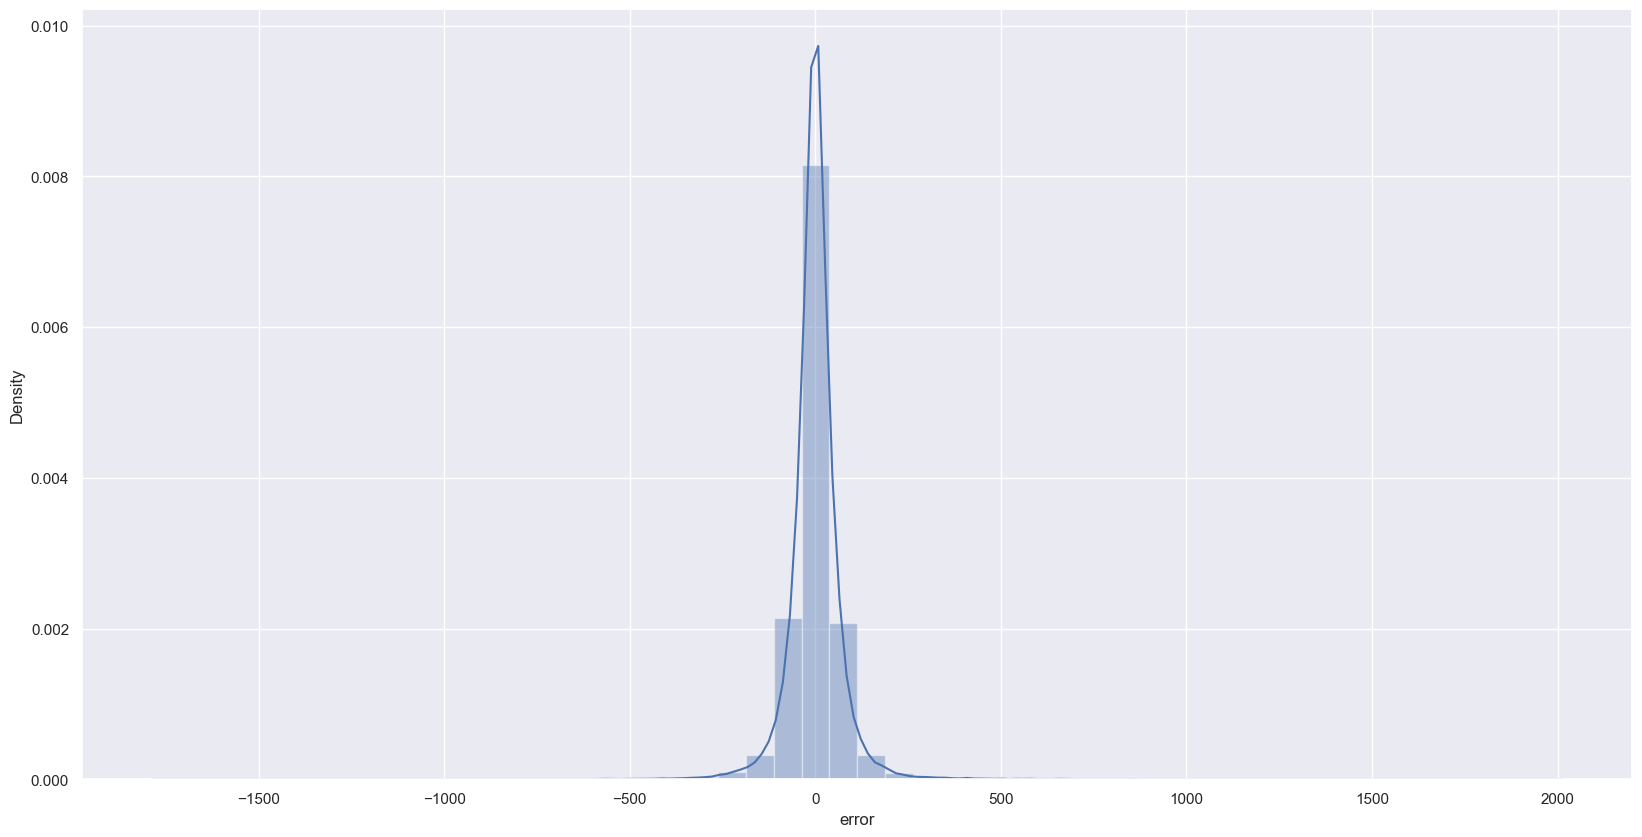

In [46]:
sns.distplot(df4_test['error']);

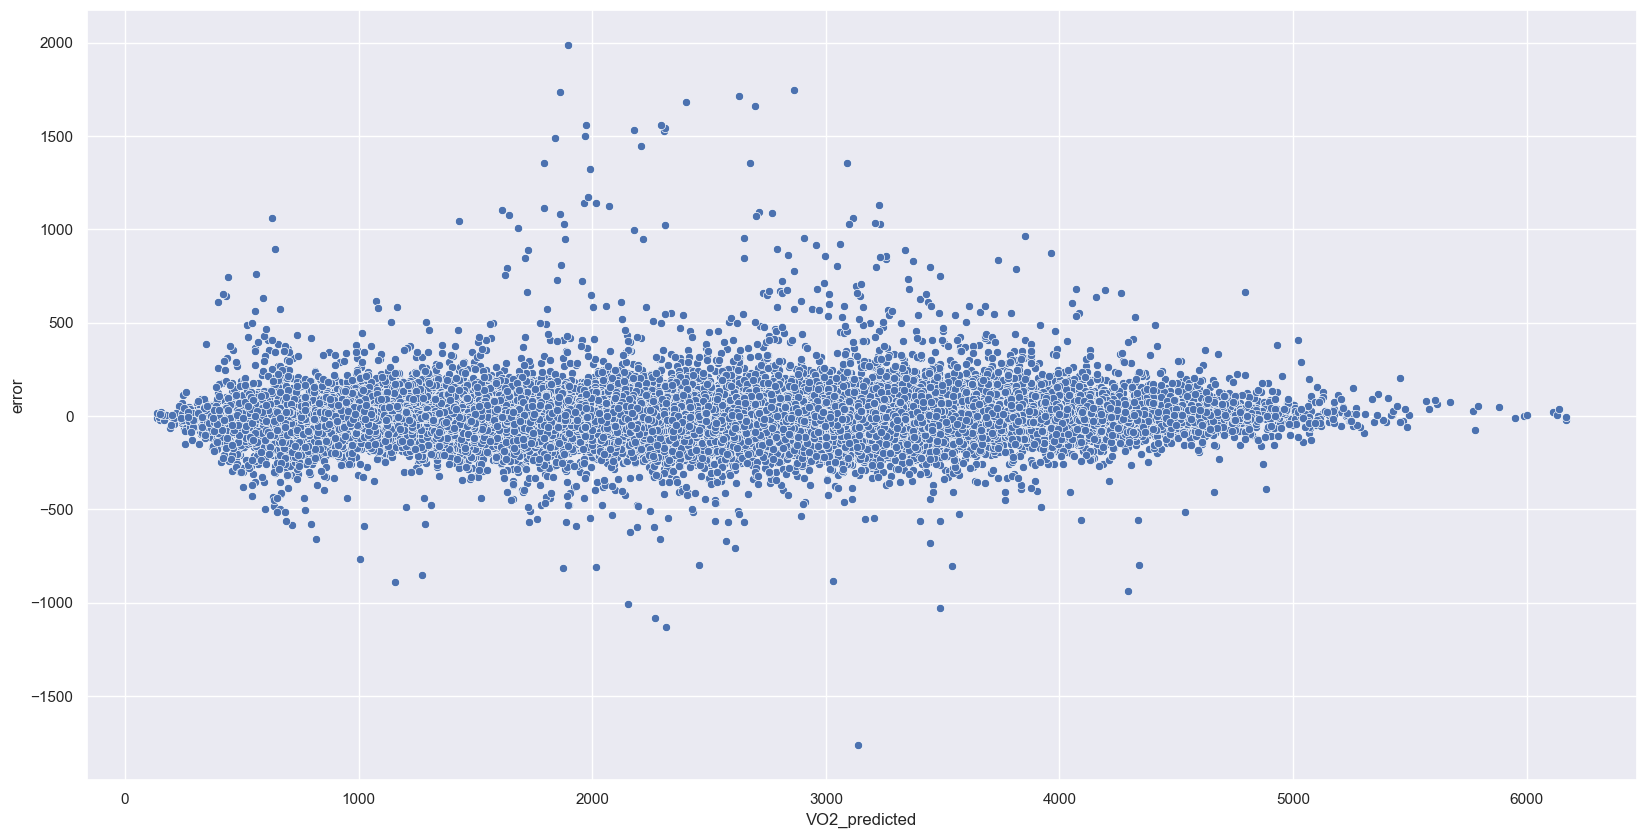

In [47]:
sns.scatterplot(x=df4_test['VO2_predicted'], y=df4_test['error']);


In [50]:
df4_test.sort_values(by='error', ascending=False).head(10)

,ID,FC,age,weight,height,gender,VO2,VO2_predicted,error
274614,594.0000,101.0000,22.6000,81.0000,186.0000,0,3885.0000,1896.7000,1988.3000
299194,485.0000,127.0000,35.3000,74.8000,182.0000,0,4611.0000,2865.5700,1745.4300
333541,503.0000,135.0000,35.2000,70.5000,186.0000,0,3598.0000,1862.8200,1735.1800
387958,412.0000,145.0000,23.8000,60.9000,171.0000,0,4344.0000,2629.9900,1714.0100
252467,513.0000,159.0000,21.3000,79.6000,178.6000,0,4085.0000,2401.5100,1683.4900
322006,746.0000,126.0000,40.4000,72.7000,174.0000,0,4357.0000,2695.3500,1661.6500
21198,537.0000,101.0000,31.2000,85.0000,182.0000,0,3534.0000,1973.4300,1560.5700
408644,512.0000,149.0000,34.1000,75.8000,176.5000,0,3849.0000,2292.1700,1556.8300
408645,513.0000,150.0000,34.1000,75.8000,176.5000,0,3857.0000,2311.9400,1545.0600
333539,501.0000,152.0000,35.2000,70.5000,186.0000,0,3714.0000,2180.0600,1533.9400


In [51]:
df4_test.sort_values(by='error', ascending=False).tail(10)

,ID,FC,age,weight,height,gender,VO2,VO2_predicted,error
345358,462.0000,93.0000,48.3000,71.0000,174.0000,0,1061.0000,1875.0100,-814.0100
195237,1.0000,104.0000,21.0000,96.0000,177.0000,0,421.0000,1272.8800,-851.8800
403418,386.0000,161.0000,36.2000,84.5000,186.0000,0,2147.0000,3031.8300,-884.8300
197356,1.0000,74.0000,20.9000,70.0000,165.0000,0,266.0000,1153.5400,-887.5400
276800,437.0000,194.0000,23.3000,72.7000,179.5000,0,3359.0000,4294.4500,-935.4500
345359,463.0000,92.0000,48.3000,71.0000,174.0000,0,1149.0000,2154.9300,-1005.9300
448515,275.0000,173.0000,18.5000,98.8000,193.0000,0,2456.0000,3486.5600,-1030.5600
148632,577.0000,156.0000,35.8000,75.0000,176.0000,0,1187.0000,2269.5600,-1082.5600
148633,578.0000,154.0000,35.8000,75.0000,176.0000,0,1188.0000,2317.7500,-1129.7500
167016,613.0000,162.0000,28.4000,82.0000,179.0000,0,1376.0000,3138.3600,-1762.3600
